
# 👷‍♀️ Lazuli Reco – Treinamento e Demonstração (Mineração de Dados)

In [4]:
!pip install matplotlib

# 1) Imports básicos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.utils.multiclass import unique_labels
import joblib

# Exibição de pandas
pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)


  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.60.1-cp310-cp310-win_amd64.whl.metadata (114 kB)
  Using cached kiwisolver-1.4.9-cp310-cp310-win_amd64.whl.metadata (6.4 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 8.1/8.1 MB 72.0 MB/s  0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.60.1-cp310-cp310-win_amd64.whl (2.3 MB)
Using cached kiwisolver-1.4.9-cp310-cp310-win_amd64.whl (73 kB)
   ---------------------------------------- 0.0/7.0 MB ? eta -:--:--
   ---------------------------------------- 7.0/7.0 MB 107.0 MB/s  0:00:00
Using cached pyparsing-3.2.5-py3-none-any.whl (113 kB)

   ---------------------------------------- 0/7 [pyparsing]
   ----- ---------------------------------- 1/7 [pillow]
   ----- ---------------------------------- 1/7 [pillow]
   ----- ----------

## 2) Carregar `dataset.csv`

In [5]:

# Ajuste este caminho se necessário. O arquivo deve estar no MESMO diretório do .ipynb (recomendado).
CSV_PATH = "dataset.csv"

df = pd.read_csv(CSV_PATH)
print("Shape:", df.shape)
display(df.head())


Shape: (3261, 19)


,tipo_cliente,total_servicos_cliente,valor_total_gasto,dias_desde_ultimo_servico,servicos_unicos_utilizados,idade_veiculo,HIST_LICENCIAMENTO,HIST_TRANSFERENCIA,HIST_VISTORIA,HIST_REVISTORIA,HIST_EMISSAO_APTVE,HIST_EMISSAO_CRLV,HIST_PLACA_CARRO,HIST_PLACA_MOTO,HIST_PLACA_REBOQUE,HIST_DESBLOQUEIOS,HIST_CONSULTA_TOTAL,HIST_DECLARACOES,target_service
0,Cliente Final,2,120.0,7,1,20,2,0,0,0,0,0,0,0,0,0,0,0,LICENCIAMENTO
1,Cliente Final,1,100.0,512,1,22,0,0,0,0,0,0,0,0,0,0,0,0,LIBERACAO_DO_PATIO
2,Cliente Final,2,120.0,15,1,13,2,0,0,0,0,0,0,0,0,0,0,0,DISTRATO
3,Cliente Final,1,60.0,92,1,19,1,0,0,0,0,0,0,0,0,0,0,0,DESBLOQUEIOS
4,Cliente Final,2,120.0,58,1,16,2,0,0,0,0,0,0,0,0,0,0,0,REVISTORIA


## 3) Verificações rápidas e tratamento simples de valores ausentes

In [6]:

# Checagem de nulos
na_counts = df.isna().sum().sort_values(ascending=False)
print("Nulos por coluna (top 20):")
display(na_counts.head(20))

# Tratamento simples: 
# - Para numéricas: preencher com 0
# - Para categóricas: preencher com 'DESCONHECIDO'
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

df[numeric_cols] = df[numeric_cols].fillna(0)
for c in categorical_cols:
    df[c] = df[c].fillna("DESCONHECIDO")

print("Após preenchimento:")
display(df.isna().sum().sort_values(ascending=False).head(5))


Nulos por coluna (top 20):


tipo_cliente                  0
HIST_EMISSAO_APTVE            0
HIST_DECLARACOES              0
HIST_CONSULTA_TOTAL           0
HIST_DESBLOQUEIOS             0
HIST_PLACA_REBOQUE            0
HIST_PLACA_MOTO               0
HIST_PLACA_CARRO              0
HIST_EMISSAO_CRLV             0
HIST_REVISTORIA               0
total_servicos_cliente        0
HIST_VISTORIA                 0
HIST_TRANSFERENCIA            0
HIST_LICENCIAMENTO            0
idade_veiculo                 0
servicos_unicos_utilizados    0
dias_desde_ultimo_servico     0
valor_total_gasto             0
target_service                0
dtype: int64

Após preenchimento:


tipo_cliente           0
HIST_EMISSAO_APTVE     0
HIST_DECLARACOES       0
HIST_CONSULTA_TOTAL    0
HIST_DESBLOQUEIOS      0
dtype: int64

## 4) Conferir coluna de alvo (`target_service`) e distribuição

Distribuição do alvo (top 20):


target_service
TRANSFERENCIA                510
LICENCIAMENTO                334
VISTORIA                     180
AUTORIZACAO_DE_ESTAMPAGEM    167
PLACA_CARRO                  165
INMETRO                      157
CADASTRO_DE_MOTOR            155
DECLARACOES                  154
DESBLOQUEIOS                 151
EMISSAO_CRLV                 150
LIBERACAO_DO_PATIO           149
REVISTORIA                   148
EMISSAO_APTVE                147
PLACA_REBOQUE                144
CONSULTA_TOTAL               142
PLACA_MOTO                   140
DISTRATO                     137
AUTORIZACAO_PREVIA           131
Name: count, dtype: int64

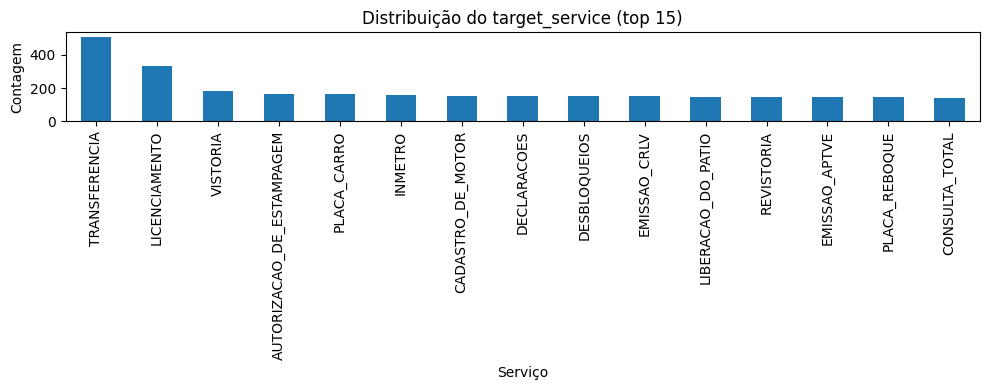

In [7]:

TARGET_COL = "target_service"
if TARGET_COL not in df.columns:
    raise ValueError(f"Coluna-alvo '{TARGET_COL}' não encontrada no dataset.")

vc = df[TARGET_COL].value_counts().sort_values(ascending=False)
print("Distribuição do alvo (top 20):")
display(vc.head(20))

# Plot simples (matplotlib, sem estilos)
plt.figure(figsize=(10,4))
vc.head(15).plot(kind="bar")
plt.title("Distribuição do target_service (top 15)")
plt.xlabel("Serviço")
plt.ylabel("Contagem")
plt.tight_layout()
plt.show()


## 5) Separar features e alvo

In [8]:

# Por padrão, usamos todas as colunas menos o alvo como features.
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

# Detectar categóricas vs numéricas
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

print("Categóricas:", cat_cols)
print("Numéricas:", num_cols)

# split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Shapes:", X_train.shape, X_test.shape)


Categóricas: ['tipo_cliente']
Numéricas: ['total_servicos_cliente', 'valor_total_gasto', 'dias_desde_ultimo_servico', 'servicos_unicos_utilizados', 'idade_veiculo', 'HIST_LICENCIAMENTO', 'HIST_TRANSFERENCIA', 'HIST_VISTORIA', 'HIST_REVISTORIA', 'HIST_EMISSAO_APTVE', 'HIST_EMISSAO_CRLV', 'HIST_PLACA_CARRO', 'HIST_PLACA_MOTO', 'HIST_PLACA_REBOQUE', 'HIST_DESBLOQUEIOS', 'HIST_CONSULTA_TOTAL', 'HIST_DECLARACOES']
Shapes: (2608, 18) (653, 18)


## 6) Montar pipeline (OneHot para categóricas) + RandomForest e treinar

In [9]:

# OneHotEncoder para as categóricas, passthrough para numéricas
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ],
    remainder="passthrough"
)

# Classificador
clf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    class_weight=None  # ajuste para 'balanced_subsample' se quiser compensar desbalanceamento
)

pipe = Pipeline([
    ("prep", preprocess),
    ("rf", clf)
])

pipe.fit(X_train, y_train)

print("Treino concluído.")


Treino concluído.


## 7) Métricas de avaliação

In [10]:

pred = pipe.predict(X_test)
acc = accuracy_score(y_test, pred)
print(f"Accuracy: {acc:.4f}\n")

print("Classification report:")
print(classification_report(y_test, pred, zero_division=0))


Accuracy: 0.1348

Classification report:
                           precision    recall  f1-score   support

AUTORIZACAO_DE_ESTAMPAGEM       0.14      0.12      0.13        34
       AUTORIZACAO_PREVIA       0.06      0.04      0.05        26
        CADASTRO_DE_MOTOR       0.06      0.06      0.06        31
           CONSULTA_TOTAL       0.03      0.04      0.03        28
              DECLARACOES       0.04      0.03      0.04        31
             DESBLOQUEIOS       0.06      0.07      0.06        30
                 DISTRATO       0.06      0.07      0.07        27
            EMISSAO_APTVE       0.10      0.07      0.08        29
             EMISSAO_CRLV       0.05      0.03      0.04        30
                  INMETRO       0.00      0.00      0.00        32
       LIBERACAO_DO_PATIO       0.07      0.07      0.07        30
            LICENCIAMENTO       0.18      0.19      0.19        67
              PLACA_CARRO       0.06      0.06      0.06        33
               PLACA

## 8) Matriz de Confusão (plot)

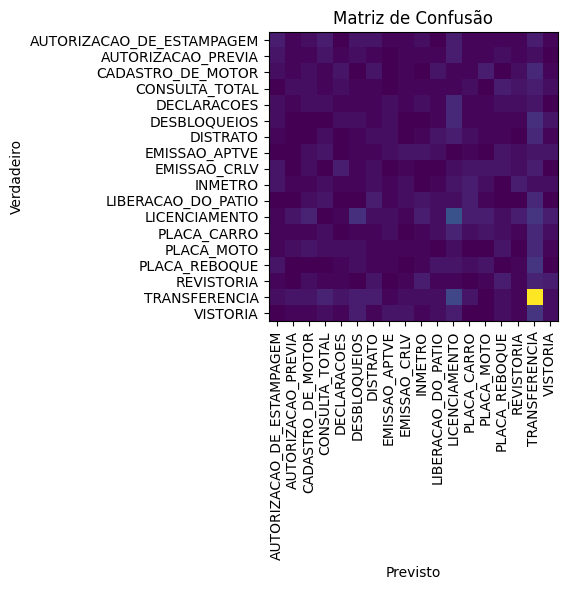

In [11]:

labels = unique_labels(y_test, pred)
cm = confusion_matrix(y_test, pred, labels=labels)

plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest')
plt.title("Matriz de Confusão")
plt.xlabel("Previsto")
plt.ylabel("Verdadeiro")
plt.xticks(range(len(labels)), labels, rotation=90)
plt.yticks(range(len(labels)), labels)
plt.tight_layout()
plt.show()


## 9) Importância de Features (top 20)

,feature,importance
4,dias_desde_ultimo_servico,0.634602
6,idade_veiculo,0.281917
3,valor_total_gasto,0.017233
7,HIST_LICENCIAMENTO,0.015513
0,tipo_cliente_Cliente Final,0.014779
2,total_servicos_cliente,0.014265
1,tipo_cliente_Parceiro,0.012867
5,servicos_unicos_utilizados,0.004802
8,HIST_TRANSFERENCIA,0.004022
14,HIST_PLACA_MOTO,0.000000


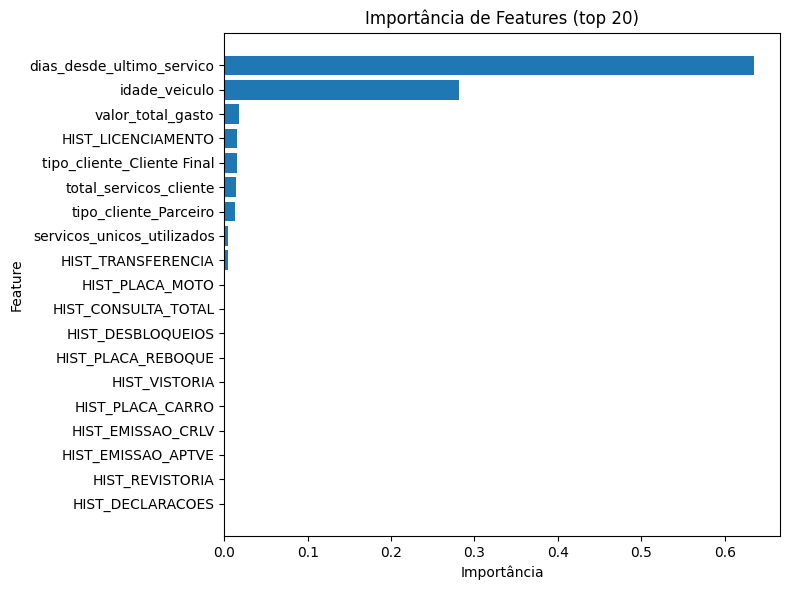

In [12]:

# Recuperar nomes das features após OneHot
ohe = pipe.named_steps["prep"].named_transformers_["cat"]
ohe_features = ohe.get_feature_names_out(cat_cols).tolist()
all_features = ohe_features + num_cols

importances = pipe.named_steps["rf"].feature_importances_
imp_df = pd.DataFrame({
    "feature": all_features,
    "importance": importances
}).sort_values("importance", ascending=False)

display(imp_df.head(20))

# Plot top 20
top = imp_df.head(20).iloc[::-1]  # invertido para barh
plt.figure(figsize=(8,6))
plt.barh(top["feature"], top["importance"])
plt.title("Importância de Features (top 20)")
plt.xlabel("Importância")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


## 10) Predição em Lote (gera `batch_predictions.csv`)

In [13]:

# Exemplo: vamos usar 10 linhas do X_test como "lote" de demonstração
lote = X_test.head(10).copy()

proba = None
try:
    proba = pipe.predict_proba(lote)
    classes = pipe.classes_
except Exception as e:
    print("Este estimador pode não suportar predict_proba. Usaremos apenas predict().", e)

pred_labels = pipe.predict(lote)

out = lote.copy()
out["pred_top_service"] = pred_labels

if proba is not None:
    # confiança = probabilidade da classe escolhida
    conf = proba.max(axis=1)
    out["confidence"] = conf

# Salvar CSV
out_path = "batch_predictions.csv"
out.to_csv(out_path, index=False)
print("Arquivo salvo:", out_path)
display(out)


Arquivo salvo: batch_predictions.csv


,tipo_cliente,total_servicos_cliente,valor_total_gasto,dias_desde_ultimo_servico,servicos_unicos_utilizados,idade_veiculo,HIST_LICENCIAMENTO,HIST_TRANSFERENCIA,HIST_VISTORIA,HIST_REVISTORIA,HIST_EMISSAO_APTVE,HIST_EMISSAO_CRLV,HIST_PLACA_CARRO,HIST_PLACA_MOTO,HIST_PLACA_REBOQUE,HIST_DESBLOQUEIOS,HIST_CONSULTA_TOTAL,HIST_DECLARACOES,pred_top_service,confidence
1324,Parceiro,1,40.0,332,1,14,1,0,0,0,0,0,0,0,0,0,0,0,AUTORIZACAO_PREVIA,0.330000
3243,Cliente Final,0,0.0,1242,0,1,0,0,0,0,0,0,0,0,0,0,0,0,DISTRATO,0.526667
1718,Cliente Final,4,240.0,39,1,24,4,0,0,0,0,0,0,0,0,0,0,0,VISTORIA,0.313333
2023,Parceiro,2,80.0,476,1,13,2,0,0,0,0,0,0,0,0,0,0,0,TRANSFERENCIA,0.583333
979,Parceiro,1,40.0,224,1,10,1,0,0,0,0,0,0,0,0,0,0,0,LICENCIAMENTO,0.263333
2991,Parceiro,3,180.0,672,2,20,2,1,0,0,0,0,0,0,0,0,0,0,LIBERACAO_DO_PATIO,0.456667
1011,Cliente Final,0,0.0,1348,0,5,0,0,0,0,0,0,0,0,0,0,0,0,DISTRATO,0.586667
2946,Cliente Final,3,180.0,948,1,20,3,0,0,0,0,0,0,0,0,0,0,0,LICENCIAMENTO,0.403333
2872,Cliente Final,3,180.0,241,1,13,3,0,0,0,0,0,0,0,0,0,0,0,CADASTRO_DE_MOTOR,0.406667
667,Cliente Final,0,0.0,2183,0,10,0,0,0,0,0,0,0,0,0,0,0,0,PLACA_CARRO,0.570000


## 11) Salvar o pipeline treinado (para futura carga pela API, se desejado)

In [14]:

MODEL_PATH = "service_reco_pipeline.joblib"
joblib.dump(pipe, MODEL_PATH)
print("Pipeline salvo em:", MODEL_PATH)


Pipeline salvo em: service_reco_pipeline.joblib
